# Naive Bayes Gaussiano

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset: Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) es un dataset con imágenes de prendas de vestir (artículos de la compañía Zalando). Son 70000 imágenes en baja resolución (28x28 pixeles), en escala de grises, agrupadas en 10 clases. Se utiliza en la comunidad de Machine Learning para comparación de algoritmos, de la misma forma que el dataset MNIST.

In [0]:
import os.path
from os import path

import time 

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import dask.dataframe as dd

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import scipy.stats as stats

import matplotlib.pyplot as plt

import pickle

if path.exists("data.txt"):
    with open ('data.txt', 'rb') as fp:
        X, y = pickle.load(fp)
else:
    with open('data.txt', 'wb') as fp:
        X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
        pickle.dump((X,y), fp)

def get_middle_divs(M):
    divisors = []
    for i in range(1,M):
        if (M%i==0):
            divisors.append(i)
    mid_div = divisors[len(divisors)//2] 
    return mid_div, M//mid_div 
            


El objetivo de esta práctica es utilizar la técnica de Naive Bayes gaussiano como clasificador de imágenes, siguiendo la notebook para obtener las respuestas del cuestionario en Campus

In [58]:
y

array(['9', '0', '0', ..., '8', '1', '5'], dtype=object)

## Exploratory Data Analysis (EDA)

In [0]:
label_dict = {
                '0':'T-shirt/top',
                '1':'Trouser',
                '2':'Pullover',
                '3':'Dress',
                '4':'Coat',
                '5':'Sandal',
                '6':'Shirt',
                '7':'Sneaker',
                '8':'Bag',
                '9':'Ankle boot'
            }

**Distribución de clases**

- ¿El dataset está balanceado? 

In [0]:
# conseguimos un dataframe donde la clase en vez de ser un numero, ahora es un string representativo
pd_clases = pd.Series([label_dict[label] for label in y]) # en y estan las clases en numeros 0,1,2...

In [61]:
pd_clases.value_counts() 

Ankle boot     7000
Dress          7000
Sneaker        7000
T-shirt/top    7000
Bag            7000
Shirt          7000
Sandal         7000
Pullover       7000
Coat           7000
Trouser        7000
dtype: int64

En este caso el dataset esta balanceado

- Redimensionar los datos de entrada con la dimensión de las imágenes

In [62]:
X.shape

(70000, 784)

In [63]:
# inicialmente son 70000 imagenes, y guardadas en un array de 784 (24x24) numeros
imgs =X.reshape(len(X),28,28) # lo reshapeo 
print(imgs.shape)

(70000, 28, 28)


**Plots**

- Graficar las primeras 150 imágenes como una grilla

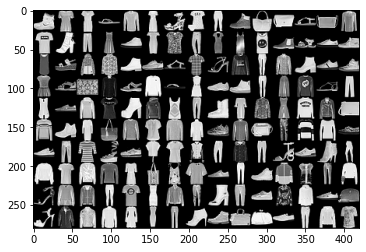

In [64]:
def get_first_n_images(n,imgs):
    ima = imgs[:n]
    M,N,O = ima.shape
    m1,m2 = get_middle_divs(M)
    for i in range(m1):
        imgs_concat = ima[i]
        for j in range(1,m2):
            imgs_concat = np.hstack((imgs_concat,ima[i+j*m1]))
         #hasta aca, imgs_concat tiene las imagenes stackeadas horizontalmente
        if i != 0:
            tot = np.vstack((tot,imgs_concat.copy()))
        else: 
            tot = imgs_concat.copy()
    return tot
total = get_first_n_images(150,imgs)
plt.imshow(total,cmap='gray')

- Graficar las primeras 100 imágenes de cada clase

Para esta parte, filtramos por clase con pandas y obtenemos los indices. Por ejemplo:

<span style="color:blue">pd_clases[pd_clases =="Bag"]</span> Realiza un filtrado por clase Bag

<span style="color:blue">pd_clases[pd_clases =="Bag"].index</span> Indices del filtrado por clase Bag

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


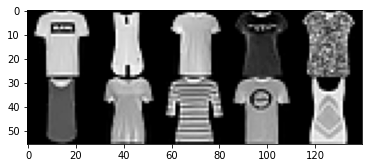

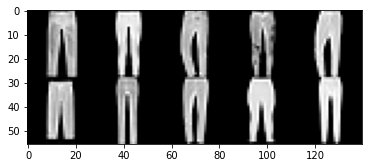

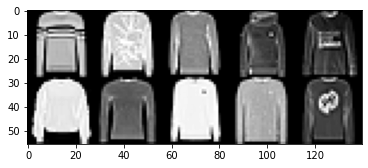

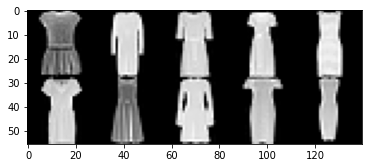

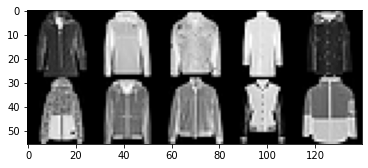

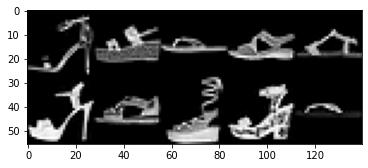

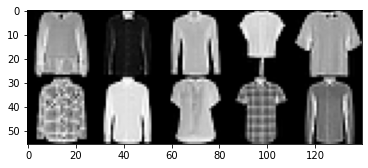

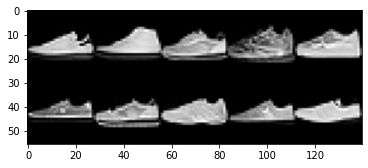

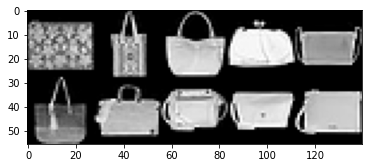

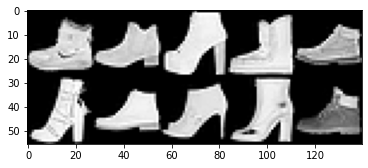

In [65]:
classes = list(label_dict.values())
print(classes)
def get_first_images_of_each_class(classes,imgs):
    for class_type in classes:
        idx = pd_clases[pd_clases ==class_type].index
        imgs_filtered = imgs[idx]
        total = get_first_n_images(10,imgs_filtered)
        plt.imshow(total,cmap='gray')
        plt.show()
get_first_images_of_each_class(classes,imgs)

**Split train-validation**

- Dividir los datos en train, validation y test, en un ratio 5:1:1, usando **random_state=42**. De forma estratificada por clases

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1+1)/(1+1+5), random_state=42, stratify = y)
# aca en X_test y en y_test se encuentran val+test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=(1)/(1+1), random_state=42, stratify = y_test)
print(len(X_train))
print(X_train.shape)
print(len(X_val))
print(len(X_test))

50000
(50000, 784)
10000
10000


Chequear que quedaron balanceados:


In [67]:
print('TRAIN')
print(pd.Series([label_dict[label] for label in y_train]).value_counts(normalize=True))

print('VALIDATION')
print(pd.Series([label_dict[label] for label in y_val]).value_counts(normalize=True))

print('TEST')
print(pd.Series([label_dict[label] for label in y_test]).value_counts(normalize=True))

TRAIN
Ankle boot     0.1
Dress          0.1
Sneaker        0.1
T-shirt/top    0.1
Bag            0.1
Shirt          0.1
Sandal         0.1
Pullover       0.1
Coat           0.1
Trouser        0.1
dtype: float64
VALIDATION
Dress          0.1
Sneaker        0.1
T-shirt/top    0.1
Bag            0.1
Shirt          0.1
Coat           0.1
Trouser        0.1
Ankle boot     0.1
Sandal         0.1
Pullover       0.1
dtype: float64
TEST
Dress          0.1
Sneaker        0.1
T-shirt/top    0.1
Bag            0.1
Shirt          0.1
Coat           0.1
Trouser        0.1
Ankle boot     0.1
Sandal         0.1
Pullover       0.1
dtype: float64


## Naive Bayes Gaussiano

**Análisis pixel por pixel**

Se puede modelar cada pixel como una variable aleatoria continua, cuyo dominio está entre 0 y 255. En ese caso, cada observación tendrá un conjunto de features: 

$X = [ X_{(0,0)},X_{(0,1)},...,X_{(0,27)},X_{(1,0)},...,X_{(27,27)} ]$

donde $X_{(i,j)}$ es la variable aleatoria del valor de gris del pixel de coordenadas i,j


- *¿Cuántas variables aleatorias se samplean para generar una imagen?* 

Rta = 28x28 = 784

**Teorema de Bayes**

Para aplicar el Teorema de Bayes es necesario conocer el **likelihood** de cada $X$ dada la clase $y$, es decir $P(X|Y)$

Por ejemplo, si se representa una imagen negra como un vector $v=[0,...,0]$ de 784 ceros. Entonces $P(X=v|Y=1)$ es el likelihood de que una imagen de clase 'Trouser' sea una imagen negra. 

Por otro lado, la probabilidad a posteriori $P(Y=1|X=v)$ es la probabilidad de que una imagen negra pertenezca a la clase 'Trouser'


¿Cómo se puede estimar $P(X|Y)$ para cada clase y para cada posible combinación de píxeles? Si se asume que hay independencia entre las variables aleatorias, se puede calcular el likelihood de $X$ como el producto de los likelihoods $X_{i,j}$ individuales: 

$P(X|Y) = P(X_{(0,0)}|Y) P(X_{(0,1)}|Y) ... P(X_{(27,27)}|Y) \rightarrow$   *Naive Bayes*  

**Distribución gaussiana**

Como se vio en la práctica anterior, el clasificador de Naive Bayes resulta útil para el caso de datos discretos, como el caso de la moneda o el clasificador de artículos. Para utilizarlo con datos continuos habría que hacer una binarización de los datos y eso usualmente aumenta mucho la cantidad de parámetros. 

Otra opción es asumir que los valores tienen una distribución gaussiana, en cuyo caso se separan los datos en las $K$ clases que se quieren diferenciar y se obtienen las medias y varianzas de cada clase. 

Si se tiene una observación $v$ que se quiere clasificar, se procede a calcular con cual de las $k$ distribuciones es más probable que la observación haya sido generada.

$p(x=v|Y_k) = \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(v-\mu_k)²}{2\sigma_k^2}} \rightarrow $ *Distribución gaussiana*

Dado que cada pixel es una variable aleatoria continua, se puede modelar como una distribución normal. 

- ¿Cuál es la media y el desvío estándar del pixel (10,10) en la clase 'Trouser' estimados a partir del set de train?

In [68]:
def get_mu_and_sigma(class_type,set_, pix1, pix2):
    pd_clases = pd.Series([label_dict[label] for label in y_train]) # en y estan las clases en numeros 0,1,2...
    idx = pd_clases[pd_clases == class_type].index
    imgs_filtered = set_[idx].reshape(len(set_[idx]),28,28)
    img_pixel = imgs_filtered[:,pix1,pix2]
    return np.mean(img_pixel),np.std(img_pixel)

mu,sigma = get_mu_and_sigma("Trouser",X_train,10,10)
print("mu ", mu, "sigma ", sigma)

mu  183.6356 sigma  58.28268707463649


- Graficar la distribución normal del pixel (10,10) de la clase 'Trouser' y de la clase 'Pullover'

Trouser mu  183.6356 sigma  58.28268707463649
Pullover mu  157.678 sigma  65.0103985220826


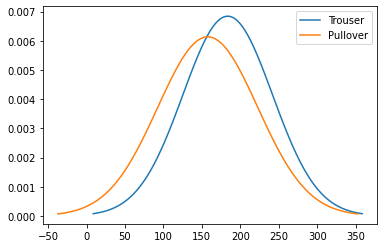

In [69]:
class_type_to_plot = ["Trouser","Pullover"]
def get_norm_dist_on_pix_for(class_type,X_train,pix1,pix2):
    return get_mu_and_sigma(class_type,X_train,pix1,pix2)

for class_type in class_type_to_plot:
    mu, sigma = get_norm_dist_on_pix_for(class_type,X_train,10,10)
    print(class_type,"mu ", mu,"sigma ",sigma)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma),label = class_type)
plt.legend()
plt.show()


- *¿Cuál es la media y el desvío estándar del pixel (14,14) en la clase 'Bag' estimados a partir del set de train?*

In [70]:
mu,sigma = get_mu_and_sigma("Bag",X_train,14,14)
print("mu: ",round(mu,3),"sigma: ",round(sigma,3))

mu:  159.418 sigma:  63.172


- Armar una matriz con la media y el desvío para cada pixel y para cada clase. Tendrá dimensión (2x784x10)
- Escribir una función para el plot de una gaussiana
- Graficar las distribuciones del pixel (10,10) para las 10 clases. 

In [0]:
def get_mat_by_class(d_classes,set_):
    mat_by_class_type = {}
    for class_type in list(d_classes.values()):
        mat = []
        for i in range(28):
            curr_list = []
            for j in range(28):
                mu, sig =get_mu_and_sigma(class_type,set_,i,j)
                curr_list.append([mu,sig])
            mat.append(curr_list.copy())
        mat_by_class_type[class_type] = mat.copy()        
    return mat_by_class_type

if path.exists("mat_mu_and_sigma.txt"):
    with open ('mat_mu_and_sigma.txt', 'rb') as fp:
        mat_by_class_type = pickle.load(fp)
else:
    with open('mat_mu_and_sigma.txt', 'wb') as fp:
        mat_by_class_type = get_mat_by_class(label_dict,X_train)
        pickle.dump(mat_by_class_type, fp)

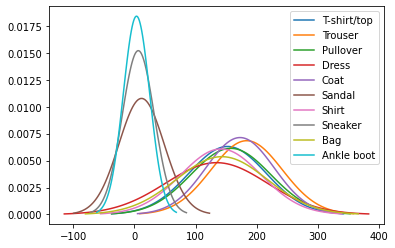

In [72]:
def plot_gaussian(class_type, mu,sigma):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=class_type)
    
for class_type in list(label_dict.values()):
    mu,sigma = mat_by_class_type[class_type][10][10]
    plot_gaussian(class_type,mu,sigma)
plt.legend()
plt.show()

**Priori, likelihood y posteriori**
- *¿Cuál es el likelihood de observar en las imágenes de 'Trouser' un valor de gris 145 en el pixel (10,10)? Estimado con el set de train*


In [78]:
def get_likelihood(x,class_type,p1,p2,mat_by_class_type):
    mu, sigma = mat_by_class_type[class_type][p1][p2]
    return stats.norm.pdf(x, mu, sigma)
    
likelihood_trouser = get_likelihood(145,"Trouser",10,10,mat_by_class_type)
print(round(likelihood_trouser,5))

0.00549


- Calcule las probabilidades a priori de las 10 clases


In [79]:
prior = pd.Series([label_dict[label] for label in y_train]).value_counts(normalize=True)
print(prior)

Ankle boot     0.1
Dress          0.1
Sneaker        0.1
T-shirt/top    0.1
Bag            0.1
Shirt          0.1
Sandal         0.1
Pullover       0.1
Coat           0.1
Trouser        0.1
dtype: float64


- *Con los dos resultados anteriores, calcule la probabilidad a posteriori no normalizada de que un valor de 145 observado en el pixel (10,10) pertenezca a una imagen de Trouser*


In [82]:
posterior_no_normalizada = get_likelihood(145,"Trouser",10,10,mat_by_class_type)*prior["Trouser"]
print(round(posterior_no_normalizada,6))

0.000549


- *Según el criterio de maximum likelihood, ¿qué clase es más probable que haya generado una imagen con un valor de gris 145 en el pixel (10,10)?*

In [83]:
max_so_far = -1 # la prob no puede ser neg
class_max = ""
for class_type in label_dict.values():
    curr = get_likelihood(145,class_type,10,10,mat_by_class_type)*prior[class_type]
    if(curr>max_so_far):
        max_so_far = curr
        class_max = class_type
    print(class_type," ",curr)
print("La clase con max posterior no normalizada es", class_max," con ",max_so_far)

T-shirt/top   0.0006266687110321171
Trouser   0.0005494751575165973
Pullover   0.000602100443399754
Dress   0.00047663000264438235
Coat   0.0006310320157452473
Sandal   1.6490637105158408e-06
Shirt   0.0006069512942785724
Sneaker   1.2990030988681348e-09
Bag   0.0005360936712248305
Ankle boot   1.0070629070318125e-12
La clase con max posterior no normalizada es Coat  con  0.0006310320157452473


**Complejidad del modelo**


- *¿Cuántos parámetros tendrá el modelo de Naive Bayes Gaussiano dado que se asumió independencia entre los píxeles?*



In [21]:
prior_num = len(label_dict) # hay una priori por clase
class_cnt = len(label_dict) # cantidad de clases
pixel_num = 28*28 # cantidad de pixeles
par_per_pixel = 2 # mu y sigma
# 2 * 784 * 10 + 10
print(par_per_pixel * pixel_num * class_cnt + prior_num)

15690


- *Si no se asume independencia, es decir que las covarianzas entre variables no se desprecian: ¿cuántos parámetros tendría el modelo?* 


In [198]:
#cada una de las posibilidades hay que tener en cuenta
#p(x0 =0 , x1 = 0 , x2 = 0 / c)
#p(x0 =1 , x1 = 0 , x2 = 0 / c)
#p(x0 =k , x1 = 0 , x2 = 0 / c) # si x toma k valores
# etc..
# tendria k*k*k  = k ** 3
print(255**784+10)

5339510688656375641538455840731393116555962390778690443912003489494981839577227757185603967798049978904307172202826399147171377297670729033203077689602086394023433014708629420971445914303826784106519755241008143812654650790551102040952797040397973011298403851361713884112857096588682250052597151862992431896799330066296380824751908849300640275125179416583367601977151440206720420860154970991756461680775894707005813403759818889382852881590881474906356606494026669008208601898168044708669657217147070237943744504922200345727585226058274190360688479671806273264968159109550023587839101427537110294006343012130644368064052181035732530107794247558480027337926682112054819895123818435594376047193447217294715813269064386236759373260435906553208424441832863917254863774192253330560177881338424361470669758018935927562446404654385560778144173794888911562811186420890929979413479586504107927316363751631797687524756350897891254405990589288932117194447871057943309481653137109867008074861244156220483214107582

## Naive Bayes Gaussiano como clasificador

- Ajustar un modelo de NB gaussiano a los datos de train. Probar ajustar el hiperparámetro de **smoothing** con los valores indicados. Considerando el accuracy promedio entre clases, ¿cuál es el mejor accuracy que obtuvo en validación? ¿Con qué valor de smoothing lo obtuvo? 


In [0]:
var_smoothings = [1,1e-1,1e-3,1e-5,1e-7]

In [87]:
max_so_far = -1
max_acc = -1
for var in var_smoothings:
    clf = GaussianNB(var_smoothing=var)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_true = y_val
    acc = accuracy_score(y_true, y_pred)
    if(max_acc < acc):
        max_acc = acc
        max_so_far = var
    print(var," ",acc)
    
print("el mejor es con",max_so_far,"con accuracy ",round(max_acc,3))

1   0.6462
0.1   0.6781
0.001   0.6557
1e-05   0.627
1e-07   0.6064
el mejor es con 0.1 con accuracy  0.678


- Clasificar los datos de test con el modelo seleccionado. Reportar accuracy. 


In [89]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

var = 0.1
clf = GaussianNB(var_smoothing=var)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_true = y_test

print(var," ",accuracy_score(y_true, y_pred))

0.1   0.6662


**Correlación entre píxeles**

En este caso, asumir independencia entre variables significa asumir que un pixel no tiene relación con su pixel vecino. Por supuesto esto es un supuesto erróneo en el caso de imágenes, donde los patrones visuales se forman gracias a la relación entre los píxeles. 

- ¿Cómo se correlaciona el valor de un pixel con sus vecinos? Calcule la matriz de correlación de cada pixel con su entorno

In [229]:
#tomamos la primera fila como ejemplo
def get_corr_pix(class_type,set_,start, pix_row,pix_col):
    pd_clases = pd.Series([label_dict[label] for label in y_train]) # en y estan las clases en numeros 0,1,2...
    idx = pd_clases[pd_clases == class_type].index
    imgs_filtered = set_[idx].reshape(len(set_[idx]),28,28)
    new_mat = np.zeros((pix_row-start,pix_col-start))
    m,n = new_mat.shape
    for i in range(pix_row-start):
        for j in range(pix_col-start):
            arr_mean = np.mean(imgs_filtered[:,start+i,start+j])
            new_mat[i,j] = arr_mean
    df = pd.DataFrame(new_mat)
    return df.corr()

corr = get_corr_pix("Trouser",X_train,10,15,15)
corr # correlacion entre columnas de new_mat
# se puede ver que hay bastante alta correlacion para un grupo de 5x5

,0,1,2,3,4
0,1.000000,-0.992866,0.962714,0.952460,0.942833
1,-0.992866,1.000000,-0.936835,-0.971401,-0.962271
2,0.962714,-0.936835,1.000000,0.835575,0.817989
3,0.952460,-0.971401,0.835575,1.000000,0.999285
4,0.942833,-0.962271,0.817989,0.999285,1.000000


**Agrupar píxeles como hiperparámetro**

Considerando ahora que cada vecindad de 4 píxeles pertenece a una misma distribución. Es decir, agrupando 4 píxeles y representando cada grupo con una única media y un único desvío estándar. 

- Si ajustásemos un modelo de NB gaussiano con esta nueva representación de variables. ¿Cuántos parámetros tendría el modelo? 

<img src="groupGaussians.png" width="400">



In [91]:
print((784/4)*10*2 + 10)

3930.0


Tendrian (784/4)x10x2 + 10 (las prioris siguen contando por separado)

- Ajustar un modelo Naive Bayes Gaussiano agrupando los píxeles de a cuatro. ¿Qué accuracy obtiene en validación con un var_smoothing de 0.1? 

Una opción es implementar sin utilizar el paquete sklearn. Para esto, se debe calcular las medias y los desvíos de las distribuciones gaussianas. Luego, preparar una función que calcule el likelihood de una clase para una imagen como el producto del likelihood del valor de gris de cada pixel de la imagen, valuando la distribución gaussiana que corresponda. Finalmente, se selecciona por maximum likelihood la clase más probable. Aplicar la función a las imágenes de validación y calcular el accuracy. 




Otra opción es acomodar el dataset para poder usar el método de sklearn. Separamos la imagen en tantas matrices como grupos de pixeles se tengan. Cada nueva matriz tendrá una muestra de cada gaussiana. 


<img src="divideImage.png">

In [0]:
def group_pixels_px_by_py(X,pixels_per_group):
    images_28_by_28 = X.reshape(-1,28,28) # convertimos a imagenes de 28x28
    m,n,o = images_28_by_28.shape
    px,py = get_middle_divs(pixels_per_group)
    expanded = np.zeros((m,n//px,o//py, pixels_per_group)) # esto va a ser de 50000,14,14,4
    m,n,o,p = expanded.shape
    for i in range(m):
        for j in range(n): 
            for k in range(o):
                pixel_group = images_28_by_28[i,j*px:j*px+px,k*py:k*py+py]  
                pixel_arr = pixel_group.reshape(pixels_per_group)
                expanded[i,j,k] = pixel_arr.copy()

    
    new_images = np.zeros((m*p,n,o)) #  esto es de 50000*4, 14, 14 
    for i in range(len(expanded)):
        for j in range(pixels_per_group):
            new_images[i*pixels_per_group+j] = expanded[i,:,:,j]
    return new_images, expanded

def group_pixels_prom(X,pixels_per_group):
    images_28_by_28 = X.reshape(-1,28,28) # convertimos a imagenes de 28x28
    m,n,o = images_28_by_28.shape
    px,py = get_middle_divs(pixels_per_group)
    prom = np.zeros((m,n//px,o//py)) # esto va a ser de 50000x14x14
    m,n,o = prom.shape
    for i in range(m):
        for j in range(n): 
            for k in range(o):
                pixel_group = images_28_by_28[i,j*px:j*px+px,k*py:k*py+py]  
                pixel_arr = pixel_group.reshape(pixels_per_group)
                prom[i,j,k] = np.mean(pixel_arr)
    return prom


def get_back_to_28_by_28(new_images,pixels_per_group):
    px,py = get_middle_divs(pixels_per_group)
    m,n,o = new_images.shape # 200000x14x14 
    new_images_28_by_28 = np.zeros((m,n*px,o*py))
    for i in range(m):
        for j in range(n):
            for k in range(o):
                new_images_28_by_28[i,j*px:j*px+px,k*py:k*py+py] = np.full((px, py),new_images[i,j,k]) # np.array(py*[image[i,j]]) 

    return new_images_28_by_28

def get_x_px_per_group(x,pixels_per_group):
    images, _ = group_pixels_px_by_py(x,pixels_per_group)
    x_28 = get_back_to_28_by_28(images,pixels_per_group)
    m,n,o = x_28.shape
    x_grouped = x_28.reshape(m,n*o)
    return x_grouped.copy()


def get_y_px_per_group(y,pixels_per_group):
    y_px = []
    for yval in y:
        y_px += int(pixels_per_group) *[yval]
    return np.array(y_px)


In [28]:
images_4, total_4 = group_pixels_px_by_py(X_train,4)
print(f'Cada imagen se convirtió en {total_4.shape[1]} matrices' )
print(f'Tenemos {total_4.shape[0]} observaciones, con {total_4.shape[1]} matrices de {total_4.shape[2]}x{total_4.shape[3]} en cada observacion')

Cada imagen se convirtió en 14 matrices
Tenemos 50000 observaciones, con 14 matrices de 14x4 en cada observacion


Convertimos cada matriz en una observación distinta

In [29]:
print(f'Tenemos {images_4.shape[0]} observaciones de dimensión {images_4.shape[1]}x{images_4.shape[2]}')

Tenemos 200000 observaciones de dimensión 14x14


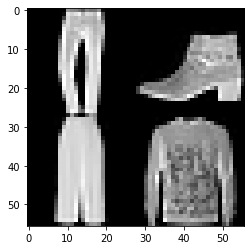

In [30]:
plt.imshow(get_first_n_images(4,X_train.reshape(-1,28,28)),cmap='gray')

Ahora repetimos cada pixel cuatro veces, para tener matrices de 28x28 nuevamente
<img src="imageTo4Images.png" width="480">

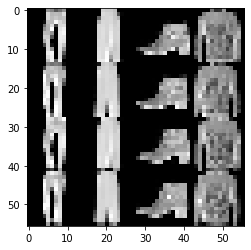

In [31]:
plt.imshow(get_first_n_images(16,images_4),cmap='gray')

In [101]:
pixels_per_group = 4 
X_t = get_x_px_per_group(X_train,pixels_per_group)
X_v = X_val.copy() 
y_t = get_y_px_per_group(y_train,pixels_per_group)
y_v = y_val.copy()
clf = GaussianNB(var_smoothing=0.1)
clf.fit(X_t,y_t)

y_pred = clf.predict(X_v)
y_true = y_v
print(accuracy_score(y_true, y_pred))

0.6423


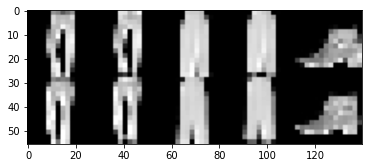

In [34]:
plt.imshow(get_first_n_images(10,X_t.reshape(-1,28,28)),cmap='gray') # chequeamos que haya vuelto a 28x28

**Búsqueda de hiperparámetros**

Mientras hacia la practica me di cuenta que podia añadir otro hiperparametro que vendria a ser el metodo de agrupar pixeles, mediante promedio o expandiendo (por ejemplo agarrar una matriz de 2x2 en el caso de agrupar de a 4 y convertirlo en un array de 1x4, consiguiendo 4 nuevas imagenes de 14x14) asi que decidi incluirlo en la busqueda de hiperparametros

- Realizar una búsqueda de hiperparámetros tipo grilla utilizando los siguientes valores de hiperparámetros:


In [19]:
hyperparameters_specs = {
    'group_method' : ["prom","expand"],
    'var_smoothings': [1,1e-1,1e-3,1e-5,1e-7],
    'pixels_per_group':  [1,4,8,14]
}

hyperparameters = pd.DataFrame()
for method in hyperparameters_specs['group_method']:
    for var in hyperparameters_specs['var_smoothings']:
        for pix in hyperparameters_specs['pixels_per_group']:
            hp = {
                'group_method' : method,
                'var_smoothings': var,
                'pixels_per_group': pix
            }
            hp_pandas = pd.DataFrame(hp, index=[0])
            hyperparameters = hyperparameters.append(hp_pandas,ignore_index=True)

#Veamos como quedo
print(hyperparameters)

   group_method  var_smoothings  pixels_per_group
0          prom    1.000000e+00                 1
1          prom    1.000000e+00                 4
2          prom    1.000000e+00                 8
3          prom    1.000000e+00                14
4          prom    1.000000e-01                 1
5          prom    1.000000e-01                 4
6          prom    1.000000e-01                 8
7          prom    1.000000e-01                14
8          prom    1.000000e-03                 1
9          prom    1.000000e-03                 4
10         prom    1.000000e-03                 8
11         prom    1.000000e-03                14
12         prom    1.000000e-05                 1
13         prom    1.000000e-05                 4
14         prom    1.000000e-05                 8
15         prom    1.000000e-05                14
16         prom    1.000000e-07                 1
17         prom    1.000000e-07                 4
18         prom    1.000000e-07                 8


- Calcular cuántos parámetros tiene el modelo para cada valor de pixels_per_group

(784/pixels_per_group)x2x10+10



In [100]:
for pix in hyperparameters_specs['pixels_per_group']:
    print("A grupos de ",pix," le corresponden", (784//pix)*2*10+10, " parametros")

A grupos de  1  le corresponden 15690  parametros
A grupos de  4  le corresponden 3930  parametros
A grupos de  8  le corresponden 1970  parametros
A grupos de  14  le corresponden 1130  parametros


## Caching

In [0]:
def get_gbpx_cache_path(hp):
    cache_path = f'cache-{hp["pixels_per_group"]}-{hp["group_method"]}'
    return cache_path

## Preprocesamiento (agrupar por pixeles)

In [9]:
%cd /content/drive/My Drive/Redes Neuronales/

/content/drive/My Drive/Redes Neuronales


In [0]:
def preprocessor(X,pixels_per_group,group_method): 
    if group_method == "expand":
        if pixels_per_group !=1:
            x_train_28_by_28 = get_x_px_per_group(X,int(pixels_per_group))
        else:
            x_train_28_by_28 = X.copy()
    else:
        if pixels_per_group !=1:
            im = group_pixels_prom(X,int(pixels_per_group))
            x_28 = get_back_to_28_by_28(im,pixels_per_group)
            m,n,o = x_28.shape
            x_train_28_by_28 = x_28.reshape(m,n*o)
        else:
            x_train_28_by_28 = X.copy()

    return x_train_28_by_28
    
def group_by_pixel_preprocessor(hp, dataset=None):
    print('group by pixel Preprocessing...')
    to = time.time()
    cache_path = get_gbpx_cache_path(hp)
    
    #Checkeamos si ya se corrió el preprocesamiento para esta combinación de hiperparámetros
    if not (os.path.exists(cache_path) and os.path.isfile(cache_path)):
        print('Cache miss: ', cache_path)
        dataset = X_train.copy()
        dataset = preprocessor(dataset,hp['pixels_per_group'],hp['group_method'])

        cache_path = get_gbpx_cache_path(hp)
        with open(cache_path, 'wb') as fp:
            pickle.dump(dataset, fp, protocol=4)
            #pickle.dump(d, open("file", 'w'), protocol=4)
        
    tf = time.time()
    print('finished in', (int(tf-to)), 'seconds.')

In [28]:
print('Preprocessing dataset...')
for index, hp in hyperparameters.iterrows():
    print(hp.to_dict())
    group_by_pixel_preprocessor(hp)

Preprocessing dataset...
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 1}
group by pixel Preprocessing...
finished in 0 seconds.
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 4}
group by pixel Preprocessing...
Cache miss:  cache-4-prom
finished in 132 seconds.
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 8}
group by pixel Preprocessing...
Cache miss:  cache-8-prom
finished in 67 seconds.
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 14}
group by pixel Preprocessing...
Cache miss:  cache-14-prom
finished in 41 seconds.
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 1}
group by pixel Preprocessing...
finished in 0 seconds.
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 4}
group by pixel Preprocessing...
finished in 0 seconds.
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 8}
group by pixel Preprocessing...
finished in 0 seconds.
{'group_m

In [0]:
def score_callback(dataset=None):
    def score_classifier(hp):
        print(hp.to_dict())        
        cache_path = get_gbpx_cache_path(hp)
        print(cache_path)
        with open (cache_path, 'rb') as fp:
            D = pickle.load(fp)
        #Aca defino el clasificador
        clf = GaussianNB(var_smoothing=hp['var_smoothings'])

        #Obtengo el score
        if hp['group_method'] == "expand":
            clf.fit(D,get_y_px_per_group(y_train,hp['pixels_per_group']))
        else:
            clf.fit(D,y_train)
        y_pred = clf.predict(X_val)
        y_true = y_val
        hp['score'] = accuracy_score(y_true, y_pred)
        
        return hp
    return score_classifier

In [30]:
print('Evaluating hyperparameters...')
to = time.time()
#print(hp)    
score_classifier = score_callback()
dhyperparameters = dd.from_pandas(hyperparameters.copy(), npartitions=os.cpu_count())
scores           = hyperparameters.apply(score_classifier, axis=1)

tf = time.time()
print('finished in', (int(tf-to)), 'seconds.')

Evaluating hyperparameters...
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 1}
cache-1-prom
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 1}
cache-1-prom
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 4}
cache-4-prom
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 8}
cache-8-prom
{'group_method': 'prom', 'var_smoothings': 1.0, 'pixels_per_group': 14}
cache-14-prom
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 1}
cache-1-prom
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 4}
cache-4-prom
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 8}
cache-8-prom
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 14}
cache-14-prom
{'group_method': 'prom', 'var_smoothings': 0.001, 'pixels_per_group': 1}
cache-1-prom
{'group_method': 'prom', 'var_smoothings': 0.001, 'pixels_per_group': 4}
cache-4-prom
{'group_method': 'prom', 'var_smoothin

In [31]:
print(scores)

   group_method  var_smoothings  pixels_per_group   score
0          prom    1.000000e+00                 1  0.6462
1          prom    1.000000e+00                 4  0.6434
2          prom    1.000000e+00                 8  0.6305
3          prom    1.000000e+00                14  0.5851
4          prom    1.000000e-01                 1  0.6781
5          prom    1.000000e-01                 4  0.6863
6          prom    1.000000e-01                 8  0.6720
7          prom    1.000000e-01                14  0.5396
8          prom    1.000000e-03                 1  0.6557
9          prom    1.000000e-03                 4  0.6696
10         prom    1.000000e-03                 8  0.6487
11         prom    1.000000e-03                14  0.4911
12         prom    1.000000e-05                 1  0.6270
13         prom    1.000000e-05                 4  0.6538
14         prom    1.000000e-05                 8  0.6420
15         prom    1.000000e-05                14  0.4901
16         pro

- ¿Qué combinación de hiperparámetros obtuvo mejor accuracy en validación? 

In [92]:
print('Training model with best hyperparameters...')

#Me quedo con la mejor combinación de hiperparámetros.
best_hp = scores.loc[scores['score'].idxmax()].drop(['score'])
print(best_hp.to_dict())

cache_path = get_gbpx_cache_path(best_hp)
with open (cache_path, 'rb') as fp:
    D = pickle.load(fp)

X_train_ = D.copy()
Y_train_ = y_train.copy()
#Creamos el clasificador para los mejores hiperparámetros

var = 0.1
clf = GaussianNB(var_smoothing=best_hp['var_smoothings'])
#Entrenamos el modelo




Training model with best hyperparameters...
{'group_method': 'prom', 'var_smoothings': 0.1, 'pixels_per_group': 4}


- Clasificar los datos de test con el modelo seleccionado y reportar accuracy

In [96]:
print('Evaluating best model...')
#Vemos el score final del modelo para test
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_true = y_test
print("accuracy: {:.4}%".format(accuracy_score(y_true, y_pred)*100))

Evaluating best model...
accuracy: 66.62%


*Nota: Los ajustes con pixels_per_group=1 corresponden al ejercicio anterior. El pixels_per_group=14 se refiere a un rectángulo de 7x2*